# Overview
In the last lab, we went over how we can use linear regression to estimate how much a voxel responds to each stimulus in an experiment. We explained the regression problem and derive it's solution. We applied this analysis to real data.

# Goals
In this lab, we will study how to make sense of the weights that we estimate from data. The regression weights of a voxel for multiple stimuli might be representative of how that voxel responds to stimuli. Alternatively, the presence of noise could have lead to weights that do not correspond to how that voxel responds to the stimulus. To distinguish between these two cases, we need to run a hypothesis test.

In [3]:
# Imports
import neurods as nds
import numpy as np
import os
import matplotlib.pyplot as plt
# Configure defaults for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

A hypothesis test is a statistical test that is used to determine whether there is enough evidence in a sample of data to infer that a certain condition is true in general. A hypothesis test examines two opposing hypotheses: the null hypothesis and the alternative hypothesis.

In the context of brain imaging experiments, we typically have a test at every voxel. For every voxel, we could have a test between:
- null hypothesis: this voxel is not responsive to faces
- alternative hypothesis: this voxel is responsive to faces

Another test could be done in the following way:
- null hypothesis: this voxel is not responsive to faces more than to places
- alternative hypothesis: this voxel is responsive to faces more than to places

As you can see above, the test cannot be defined without a proper specification of its null and alternative hypotheses. Multiple tests could be done with the same data and the estimates we derive from it. A correct formulation of the test will guide the statistical procedure to be done and will help to arrive at a statistically sound hypothesis.

In a typical fMRI experiment, we convolve the stimulus design matrix with a canonical hemodynamic response function and we use this to estimate weights for each condition at each voxel. We saw in class and in the homework how we can plot these estimated weights.

In [ ]:
from numpy.linalg import inv
def OLS(X,Y):
    return np.dot(inv(np.dot(X.T,X)),np.dot(X.T,Y))

# Modeling voxel responses

Remember, we are using regression because we want to model different voxel responses to a set of stimuli. We learned how to take a stimulus time course and how to convolve it with the hemodynamic response. We then assumed that each voxel's activity was a linear combination of all the convolved time courses of the stimuli. We want to recover the parameters of the linear combination. Let's load some data:

In [ ]:
basedir = os.path.join(nds.io.data_list['fmri'],'categories')
design = np.load(os.path.join(basedir,'experiment_design.npz'))
print('Experiment design variables: ', design.keys())
conditions = design['conditions'].tolist()
print('Conditions: ', conditions)
design_run1 = design['run1']
for i, (cond, label) in enumerate(zip(design_run1.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

We are going to use the zscore function while loading the data to normalize every block:

In [ ]:
import cortex
sub, xfm = 'S2', 'S2_category_auto'
mask = cortex.db.get_mask(sub, xfm, type='cortical')
fname = os.path.join(basedir, 'S2_categories1_{n}.nii.gz') #S2_categories1_{n}.nii.gz
# fmri responses:
Y = np.vstack([zscore(nds.fmri.load_data(fname.format(n=n), mask=mask, standardize=True)) for n in [1,2]])
# stimuli:
X = np.vstack([design[run] for run in ['run1','run2']])

plt.figure(figsize=(10,4))
plt.imshow(Y)
plt.title('Voxel responses')

plt.figure(figsize=(10,4))
for i, (cond, label) in enumerate(zip(X.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

We need to first build a design matrix that accounts for the hemodynamic response:

In [ ]:
from neurods.fmri import hrf as generate_hrf
t_hrf, hrf_1 = generate_hrf(tr=2)
n, d = X.shape

conv_X = np.zeros_like(X)
for i in range(d):
    conv_X[:,i] = np.convolve(X[:,i], hrf_1)[:n]
    
for i, (cond, label) in enumerate(zip(conv_X.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
    
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

We want to find the response of all the voxels in the brain to these 5 different conditions. Instead of a one dimensional output $Y$, we have a high dimensional output ${\bf Y}$.

In [ ]:
weights = OLS(conv_X, Y)
print('shape of weights is {}'.format(weights.shape))
plt.imshow(weights)
for idx, condition in enumerate(conditions):
    vol = cortex.Volume(weights[idx], sub, xfm, mask = mask)
    __  = cortex.quickflat.make_figure(vol)
    plt.title(condition, fontsize = 30)

- What can we conclude from the above plots about where different categories are represented in the brain?
- Can we trust very high weights more than small weights? How can we know what a good threshold is?

In order to make inferences about brain representations from the result of our linear regression, we first need to estimate an appropriate statistic from the data. We will perform something called a t-test.

First, we need to estimate the mean squared error. The weights above were obtained using matrices conv_X (the convolved design matrix), and Y (the data matrix). 

#### Breakout Session
- First, use the weights estimated above to predict the activity $\hat {\bf Y}$.
- Second, estimate the error ${\bf Y-\hat Y}$.
- Then, estimate $\boldsymbol \sigma$, the mean squared error $\sum_{i=0}^{N-1}(Y_i - \hat Y_i)^2$. This will give you a vector corresponding to the mean squared error at every voxel.
- Make a flatmap of $\boldsymbol \sigma$

In [ ]:
# start by using the variables conv_X and weights to estimate Y_hat
# you should estimate a variable mse
# then use to plot it the following:
# vol = cortex.Volume(mse, sub, xfm, mask = mask)
# __  = cortex.quickflat.make_figure(vol)
# plt.title('mse', fontsize = 30)

### STUDENT ANSWER
Y_hat = conv_X * weights
error = Y - Y_hat
mse = np.sum((Y - Y_hat)**2, axis=0)
vol = cortex.Volume(mse, sub, xfm, mask = mask)
__  = cortex.quickflat.make_figure(vol)
plt.title('mse', fontsize = 30)

Now we need to define the notion of a contrast. In the homework, you were asked to subtract the weights for places from the weights for faces. This can be called a faces - places contrast. A contrast can be computed using a vector of d numbers. In our case, d=5 because we have 5 conditions.

To compute the faces - places contrast, we can use the following contrast [0,1,0,-1,0]. 

In [2]:
c = np.array([0,1,0,-1,0])
contrast = np.dot(c,weights)
vol = cortex.Volume(contrast, sub, xfm, mask = mask)
__  = cortex.quickflat.make_figure(vol)
plt.title('faces - places', fontsize = 30)

NameError: name 'np' is not defined

What do we use this contrast with? We want to find the regions that are more responsive to faces than to places. Therefore, for every voxel, we have the following:
- null hypothesis: this voxel is not responsive to faces more than to places
- alternative hypothesis: this voxel is responsive to faces more than to places

Let's say a particular alternative hypothesis is actually correct, for example, a voxel $v$ does represent faces (in reality, we can never know this fact). 

If the alternative hypothesis is correct and our test doesn't reject the null hypothesis, we call this a type II error. In case where the null hypothesis is correct and we reject it, this is called a type I error, or a false positive.

The probability of rejecting a null hypothesis when the alternative is correct, e.g. of correctly concluding that voxel $v$ does represent faces, is called the power of a test. The power depends on many properties of an experiment, of the test and of the hypotheses. Critical parameters of the experiment that can affect the power are for example the level of noise in the experiment, the effect size, the number of samples.

We want a test that maximizes power. However, take the following test: always reject the null hypothesis. This test does maximize power, however, it also maximizes type I error. The opposite test: never reject the null hypothesis, minimize type I error, but it also makes the power equal to zero. We therefore want a test that maximizes power while keeping the false positive rate under an acceptable threshold.

We cannot guarantee that we are making no type I errors. However, statistical tests have a guarantee on the probability of error. Depending on which test we use, we estimate a p-value for our observations. A p-value is defined as the probability of obtaining a result equal to or "more extreme" than what was actually observed, when the null hypothesis is true. We then reject the null hypothesis if the p-value is lower than some threshold. 0.05 is for example a common threshold for tests. If we reject with this rate, it means that the probability of us making a mistake is less than 0.05. 

Let's say the null hypothesis is actually true. Using a threshold of 0.05 actually means that if we could somehow repeat the experiment a large number of times, we would (falsely) reject the null hypothesis 5% of those times.

A t-test allows us to estimate a statistic that can be readily converted into a p-value.

For each voxel $v$, the t-statistic is the contrast value, divided by the standard error of the contrast. The standard error of the contrast is estimated as: $\sqrt{\hat{\sigma_v}^2 c^T (X^T X)^{-1}c}$. Therefore the t-statistic at that voxel is 

$$ t_v = \frac{c^T \hat\beta_v}{\sqrt{\hat{\sigma}^2 c^T (X^T X)^{-1}c}}$$

#### Breakout Session

- Implement a function that takes as input the convolved design matrix, the weights of all voxels, the mse vector $\boldsymbol \sigma$ and the vector c. This function should output the value of the t-statistic for every voxel. 
- Use this function to estimate the t-statistic for each voxel with the contrast corresponding to faces - places
- Produce a flatmap of those t-statistics 


In [ ]:
# implement the function below, then use it with the existing variables:
# t_statistic = t_stat(conv_X, weights, mse, [0,1,0,-1,0])
# vol = cortex.Volume(t_statistic, sub, xfm, mask = mask)
# __  = cortex.quickflat.make_figure(vol)
# plt.title('t_statistic', fontsize = 30)
from numpy.linalg import inv

def t_stat(X, beta, mse, c):
### STUDENT ANSWER
    num = np.dot(c,beta)
    ctXtXc = np.dot(np.dot(c, inv(np.dot(X.T,X)) ), c)
    denum = np.sqrt(mse* ctXtXc)
    return num/denum

t_statistic = t_stat(conv_X, weights, mse, [0,1,0,-1,0])
vol = cortex.Volume(t_statistic, sub, xfm, mask = mask)
__  = cortex.quickflat.make_figure(vol)
plt.title('t_statistic', fontsize = 30)
    

We can convert t-statistics to p-values. The distribution of a t-statistic is determined by it's degree of freedom $\nu$. For us, $\nu$ corresponds to the number of datapoints used to estimate the statistic, i.e. the original number of samples (240).

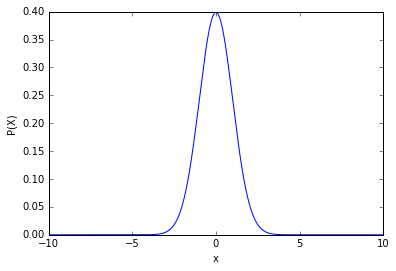

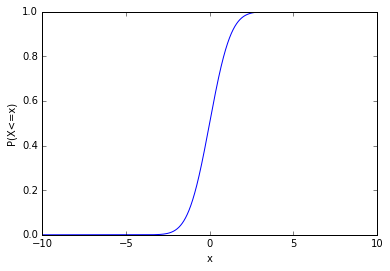

In [15]:
nu = 240# Y.shape[0]
from scipy.stats import t as tdistribution
x = np.linspace(-10,10,num=10001)
t_pdf = tdistribution.pdf(x, nu)
plt.figure()
plt.plot(x,t_pdf)
plt.xlabel('x')
plt.ylabel('P(X)')
plt.figure()
t_cdf = tdistribution.cdf(x, nu)
plt.plot(x,t_cdf)
plt.xlabel('x')
plt.ylabel('P(X<=x)');

We can use the function tdistribution.cdf to estimate a p-value for the contrast at every voxel. Remember, cdf(x) is the probability of obtaining a value smaller than x. We want the p-value, which is the probability of obtaining a value higher than x, which is 1-cdf(x). 


In [16]:
p_statistic = 1 - tdistribution.cdf(t_statistic,nu)
vol = cortex.Volume(p_statistic, sub, xfm, mask = mask)
__  = cortex.quickflat.make_figure(vol)
plt.title('p_statistic', fontsize = 30)
vol = cortex.Volume(-np.log10(p_statistic), sub, xfm, mask = mask)
__  = cortex.quickflat.make_figure(vol)
plt.title('p_statistic, log scale', fontsize = 30)

NameError: name 't_statistic' is not defined

- What happens if we now threshold the brain at p<=0.05? 

In [ ]:
vol = cortex.Volume(p_statistic<=0.05, sub, xfm, mask = mask, vmin = -2, vmax = 2)
__  = cortex.quickflat.make_figure(vol)
plt.title('p<=0.05', fontsize = 30)

In 1998 (?), a group of researchers were able to show that a group of voxels in a dead salmon were responsive to a visual stimulus. Of course, this study was designed to show the perils of failing to control for multiple comparisons.

Let's say there is a game in which a person has to pick a slot out of 100 and win a big prize. On the first try, that person guesses the correct slot.
- What is the probability of that event happening by chance?
- Would you be willing to suppose this person was previously told about which slot was correct?

Now assume you have 10000 people playing this game. On their first try, 109 people guess the correct slot and win the prize.
- Would you be willing to suppose these people were previously told about which slot was correct?
- Would your assumption change if 5000 people guess the correct slot on their first try?
- How does this relate to our problem?

## Multiple comparison correction

Multiple methods exist to perform multiple comparison correction. Familywise Error Rate (FWER) control the chance of getting any false positives. 

For example, when correcting for M multiple comparison, the Bonferroni correction consist of using a rate of $\alpha/M$ instead of $\alpha$.

This is a conservative test: to avoid false positives, it makes the rate very small and thus might fail to reject many true positives.

In [20]:
alpha = 0.05
M = Y.shape[1]
alpha_bonferroni = alpha/M
vol = cortex.Volume(p_statistic<=alpha_bonferroni, sub, xfm, mask = mask, vmin = -2, vmax = 2)
__  = cortex.quickflat.make_figure(vol)
plt.title('Bonferroni correction', fontsize = 30)

NameError: name 'Y' is not defined

Other, less conservative FWER methods exist. Another method is to correct for the False Discovery Rate (FDR), i.e. limit the proportion of false positives among the rejected tests. One famous method is the Benjamini Hochberg Procedure. We implement it for you below and use it to control the FDR at q = 0.05:

In [ ]:
def FDR_BH(p_vals, q):
    M = p_val_sorted.shape[0]
    # sort the p_values
    p_val_sorted = np.sort(p_vals)
    threshold = 0
    # go the p_values in order and find the largest k where P(k) <= k/M*q
    for idx,p in enumerate(p_val_sorted):
        if p <= idx*q/M:
            threshold = p
        else
            break
    return threshold

vol = cortex.Volume(p_statistic<=alpha_bonferroni, sub, xfm, mask = mask, vmin = -2, vmax = 2)
__  = cortex.quickflat.make_figure(vol)
plt.title('FDR correction', fontsize = 30)

You can see how this method rejects the null hypothesis at more voxels. Both methods control for multiple comparisons.

## Predicting withheld data:

Another method for testing if the weights of a learned model are meaningful and not due only to chance is to test them to predict new, unseen data. The idea is that if the weights we estimated are indicative of how the brain responds to the experimental conditions, then we can use them to predict the brain response for new data. Here, we introduce concepts that are very important for the statistics and machine learning fields:

- Training set: is the part of the data you use to estimate your model. You can use this data as you wish. We will discuss overfitting next week and see why you might want to be careful with how much of the variance of this data you want your model to predict.
- Test set: this test should remain untouched until the very end of your analysis, where you only use it to report your results. You should never go back to your analysis and change any parameters based on the performance of your model on the test set. 

We did not use yet the third run of our experiment. We will load it here and use it to test the performance of our model on it:

In [22]:
import cortex
sub, xfm = 'S2', 'S2_category_auto'
mask = cortex.db.get_mask(sub, xfm, type='cortical')
fname = os.path.join(basedir, 'S2_categories1_{n}.nii.gz') #S2_categories1_{n}.nii.gz
# fmri responses:
Y_test = np.vstack([zscore(nds.fmri.load_data(fname.format(n=n), mask=mask, standardize=True)) for n in [3]])
# stimuli:
X_test = np.vstack([design[run] for run in ['run3']])


plt.figure(figsize=(10,4))
for i, (cond, label) in enumerate(zip(X_test.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

conv_X_test = np.zeros_like(X_test)
for i in range(d):
    conv_X_test[:,i] = np.convolve(X_test[:,i], hrf_1)[:n]
    

KeyError: 'S2'

#### Breakout Session

Using the weights you have estimated before:
- First, use conv_X_test to predict the activity $ {\bf \hat Y_{test}}$.
- Second, estimate the error ${\bf Y_{test}-\hat Y_{test}}$.
- Then, estimate $\bf \boldsymbol \sigma_{test}$, the mean squared error $\sum_{i=0}^{N-1}({Y_{test}}_i -  {\hat Y_{test}}_i)^2$. This will give you a vector corresponding to the mean squared error at every voxel.
- Compute the coefficient of determination, which estimates how much of the data is being predicted:
    $R^2_{\bf test} = 1 - \frac{\bf \boldsymbol \sigma_{test}}{var({\bf Y_{test}})} $.
    Since we have already normalized every voxel to have a variance of 1, you can simplity the computation to:
    $R^2_{\bf test} = 1 - \bf \boldsymbol \sigma_{test} $
- Produce a flatmap of $R^2_{\bf test}$
- Then, use the previously computed $\boldsymbol \sigma$ using training data to produce a flatmap of $R^2_{\bf train} = 1 - \bf \boldsymbol \sigma_{} $

In [ ]:
# start by using the variables conv_X_test and weights to estimate Y_hat_test
# you should estimate a variable mse_test
# then use to plot it the following:
# vol = cortex.Volume(1-mse_test, sub, xfm, mask = mask)
# __  = cortex.quickflat.make_figure(vol)
# plt.title('R2 test', fontsize = 30)
# then plot the training R2:
# vol = cortex.Volume(1-mse, sub, xfm, mask = mask)
# __  = cortex.quickflat.make_figure(vol)
# plt.title('R2 train', fontsize = 30)

### STUDENT ANSWER
Y_hat_test = conv_X_test * weights
error = Y_test - Y_hat_test
mse_test = np.sum((Y_test - Y_hat_test)**2, axis=0)
vol = cortex.Volume(1-mse_test, sub, xfm, mask = mask)
__  = cortex.quickflat.make_figure(vol)
plt.title('R2 test', fontsize = 30)
then plot the training R2:
vol = cortex.Volume(1-mse, sub, xfm, mask = mask)
__  = cortex.quickflat.make_figure(vol)
plt.title('R2 train', fontsize = 30)

- What is the difference between the two plots?

Additionally, one of the big fallacies in the fMRI litterature was something called double dipping. you should be careful to never use the same data to make and test your hypotheses! 